# Analysis of the Experimental Results
Apply multivariate analysis of the experimental results

## Questions to investigate
For each of the clustering methods which one provides the best clustering of stations for the variants of epsilon nad maxPts. Best clustering can be defined as:
1. Most number of clusters with most number of stations (i.e. least noise)
1. Maximum quality measure with the silhouette coefficient, calinzki-harabaz score, davis-bouldin score, and dunn index

In [1]:
'''
    WARNING CONTROL to display or ignore all warnings
'''
import warnings; warnings.simplefilter('default')     #switch betweeb 'default' and 'ignore'

''' Set debug flag to view extended error messages; else set it to False to turn off debugging mode '''
debug = True

### Get station data

___Note:___ You may skip retrieving data and running the prolonged clustering process and simply work analyze the quality measures from the ```results.csv``` file stored in the ```experiments``` folder.

In [2]:
''' Get all stations  '''
import sys
sys.path.insert(1, '../lib')
import stations

try:
    print('Please wait while we retrieve GeoNet station inventory data')
    cls_st = stations.station_data()
    __client = cls_st.get_client()
    st_list, invalid_st_list, _ = cls_st.get_stations(__client)
    if not st_list:
        raise TypeError

    print(f'In the inventory of {len(st_list)+len(invalid_st_list)} total station')
    print(f'There are {len(st_list)} active stations inside the main geographic land boundaries.')
    print(f'and {len(invalid_st_list)} active stations outside the main geographic land boundaries.')
    print('Complete')

except Exception as err:
    print("Error message:", err)
    if debug:
        import traceback
        print(traceback.format_exc())

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Please wait while we retrieve GeoNet station inventory data


/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


In the inventory of 455 total station
There are 452 active stations inside the main geographic land boundaries.
and 3 active stations outside the main geographic land boundaries.
Complete


In [3]:
import pandas as pd

try:
    ''' Define the list of station types to filter the station inventory data '''
    __lst_st_type_80Hz_above = ['EH']
    lst_st_80Hz_above = [[st_name,st_type, st_lat,st_lon]
                         for st_name,st_type,st_lat,st_lon in st_list
                         if st_type in __lst_st_type_80Hz_above]
    station_df = pd.DataFrame(lst_st_80Hz_above, columns=['st_name','st_type','st_lat','st_lon'])

    ''' Initialize label column as -1 indicating individual stations to be noise to begin with '''
    l_label = [-1]*station_df.shape[0]
    station_df['label'] = -1
    station_df.set_index(['st_type','label'])

    print('%d stations of type %s are ready for clustering' % (station_df.shape[0],__lst_st_type_80Hz_above))

except Exception as err:
    print("Error message:", err)
    if debug:
        import traceback
        print(traceback.format_exc())

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


117 stations of type ['EH'] are ready for clustering


### Get clustering sequence parameters

In [76]:
''' Get clustering experiment sequence parameters from the spreadsheet '''
import pandas as pd
import sys; sys.path.insert(1, '../lib')
import cluster_quality as cq
#import graph_clustering as gc
import importlib
cq = importlib.reload(cq)
#gc = importlib.reload(gc)

import sys
import time
#import traceback

''' Set file names to read clustering sequence and write results to;
    including writing clusters that cannot be validated for quality'''
_s_seq_input_file = "./cluster_runs.csv"
_s_results_file = "./results.csv"
_err_file = open("./err_clustering.txt",'w')
#_s_seq_input_file = "./cluster_runs_kmeans.csv"
#_s_results_file = "./results_kmeans.csv"
#_err_file = open("./err_clustering_kmeans.txt",'w')

''' declare quality class, results dataframe, and number of erros '''
clust_quality = cq.cluster_quality_metric()
results_df_ = pd.DataFrame([])     # dataframe to store the results
_n_errs = 0

''' Load data from CSV '''
_run_seq_df = pd.read_csv(_s_seq_input_file)
print('File %s contains clustering strategies for processes\n%s'
      % (_s_seq_input_file, sorted(_run_seq_df['name'].unique())))
print('Start clustering and acquire quality parameters for %d strategies' % _run_seq_df.shape[0])
print('This may take a while ...\n')
for exp_seq in range(_run_seq_df.shape[0]):
    s_clust_cls_, s_clust_name_, dict_params_ = clust_quality.get_seq_params(_run_seq_df, exp_seq)
    st_clust_df_ = pd.DataFrame([])     # dataframe for the stations and cluster labels
    st_clust_df_ = clust_quality.get_clusters(dict_params_,
                                              station_df,
                                              s_clust_cls_,
                                              s_clust_name_)
    _n_clusters = len([x for x in st_clust_df_['label'].unique() if x > -1])

    if _n_clusters > 1:
        clust_quality.set_quality_frame(clustering_name=s_clust_name_, **dict_params_)
        results_df_=results_df_.append(clust_quality.get_quality_metrics(st_clust_df_))

    else:
        _n_errs += 1
        _s_err = s_clust_name_+': '+''.join(str(dict_params_.keys()))
        _s_err += '\n'+''.join(str(dict_params_.values()))+'\n'
        _err_file.write(_s_err)
        print('No results were added for %s' % _s_err)

if results_df_.shape[0] > 0:
    l_seq = list(range(0,(results_df_.shape[0])))
    results_df_.insert(0, 'Sequence', l_seq)
    results_df_.set_index('Sequence')
    results_df_.to_csv(_s_results_file, index=False)

_err_file.close()
    
print('Of %d sequences the quality metric results for %d sequences are stored in %s' 
      % (exp_seq+1,exp_seq+1-_n_errs,_s_results_file))

File ./cluster_runs_kmeans.csv contains clustering strategies for processes
['KMEANS']
Start clustering and acquire quality parameters for 140 strategies
This may take a while ...

Of 140 sequences the quality metric results for 140 sequences are stored in ./results_kmeans.csv


## Load, Prepare and Enrich Quality Metrics

In [77]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

_s_seq_input_file = "./results.csv"
#_s_seq_input_file = "./results_kmeans.csv"
_results_df=pd.read_csv(_s_seq_input_file)
#_results_df.head()

lst_drop_cols = ['Sequence', 'Station Types', 'Station Quantity', 'Metric']
_results_df = _results_df.drop(lst_drop_cols,axis=1)

lst_norm_cols = list(["Silhouette Coefficient","Calinski Harabaz score","Davies Bouldin score",
                      "Dunn Index","Modularity","Conductance Average","Coverage Score","Performance Score"])
_results_df[lst_norm_cols] = _results_df[lst_norm_cols].apply(pd.to_numeric)
''' rename attributes '''
_results_df=_results_df.rename(columns={"Maximum Distance": "maxDist", "Minimum Points": "minPts"})
_results_df.loc[_results_df.Name == "LPC", "Name"] = "LABEL PROPAGATION"
''' append algorithm and method to name '''
_results_df['Cluster Sequence'] = (_results_df['Name']+' '+_results_df['Algorithm']+
                                   ' '+_results_df['Method']+' '+_results_df['Seed'])
_results_df['Cluster Sequence'] = _results_df['Cluster Sequence'].str.replace("None","")
_results_df['Cluster Sequence'] = _results_df['Cluster Sequence'].str.replace("   ","-")
_results_df['Cluster Sequence'] = _results_df['Cluster Sequence'].str.replace(" ","-")
_results_df['Cluster Sequence'] = _results_df['Cluster Sequence'].str.rstrip("-")
_results_df.info()
#print(_results_df['Cluster Sequence'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293 entries, 0 to 292
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   maxDist                  293 non-null    int64  
 1   minPts                   293 non-null    int64  
 2   Name                     293 non-null    object 
 3   Algorithm                293 non-null    object 
 4   Method                   293 non-null    object 
 5   Seed                     293 non-null    object 
 6   Generated Cluster Count  293 non-null    int64  
 7   Valid Cluster Count      293 non-null    int64  
 8   Clustered Station Count  293 non-null    int64  
 9   Unclsutered Noise Count  293 non-null    int64  
 10  Average Node Degree      293 non-null    float64
 11  Silhouette Coefficient   293 non-null    float64
 12  Calinski Harabaz score   293 non-null    float64
 13  Davies Bouldin score     293 non-null    float64
 14  Dunn Index               2

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



### Normalize quality measures

In [78]:
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#scaler = StandardScaler()
scaler = MinMaxScaler()

_norm_df = _results_df.copy()
#lst_norm_cols = list(['Silhouette Coefficient',
#                      'Calinski Harabaz score',
#                      'Davies Bouldin score',
#                      'Dunn Index'])
for col in lst_norm_cols:
    scaled = scaler.fit_transform(np.array(_norm_df[col]).reshape(-1,1))
    _norm_df[col] = pd.DataFrame(scaled)
_norm_df = _norm_df.dropna()
print('Normalization complete!')

Normalization complete!


/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



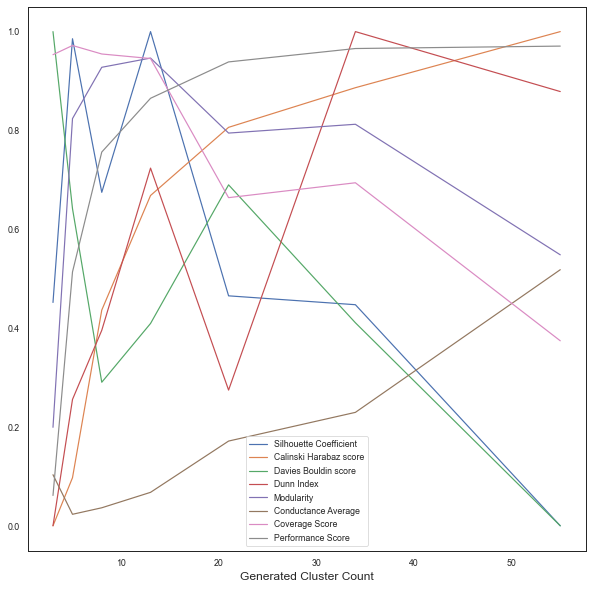

In [73]:
import matplotlib.pyplot as plt

group_df = _norm_df.groupby("Generated Cluster Count")[["Silhouette Coefficient",
                                                        "Calinski Harabaz score",
                                                        "Davies Bouldin score",
                                                        "Dunn Index",
                                                        "Modularity",
                                                        "Conductance Average",
                                                        "Coverage Score",
                                                        "Performance Score"]].mean()
#group_df = _norm_df[["Generated Cluster Count","Silhouette Coefficient"]]

#print(group_df.head)
#plt.plot(group_df, '-o')
group_df.plot()
plt.show()

### Correlation matrix
We [plot the correlation matrix](https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e) to determine if there is a single cluster quality measure we could use to analyze the clusters for each combination of clustering method, epsilon, and minPts.
* Calinski Harabaz score is positively correlated with Silhouette coefficient and the Dunn Index but negatively correlated with Davies Bouldin score; therefore, we can eliminate the Calinski Harabaz score
* However, the Silhouette coefficient, Davies Bouldin score and the Dunn Index are negatively correlated with each other
* The Silhouette coefficient and the Davies Bouldin score are closer to 0 implying we may select on of them as the quality measure.
* The **Davies Bouldin score** is furthest away from the Dunn Index and the Calinski Harabaz score, which implies it would it be the preffered choice to select as the single cluster qulity indicator.

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



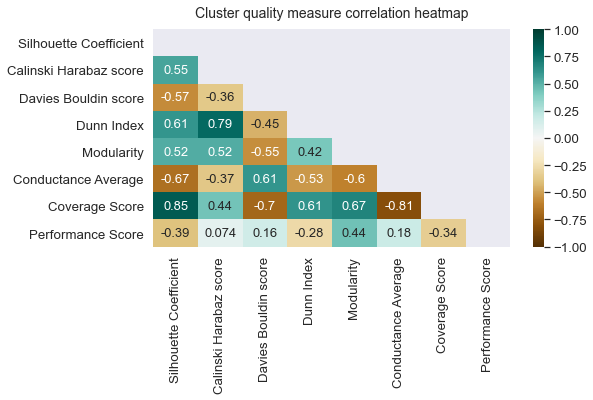

In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

_corr_plt_df = _norm_df[lst_norm_cols]
plt.figure(figsize=(8,4))
mask = np.triu(np.ones_like(_corr_plt_df.corr(), dtype=np.bool))

sns.set(font_scale=1.2)
heatmap = sns.heatmap(_corr_plt_df.corr(), mask=mask,
                      vmin=-1,vmax=1,annot=True,annot_kws={"size": 13},cmap='BrBG')
heatmap.set_title('Cluster quality measure correlation heatmap',fontdict={'fontsize':14}, pad=12)
plt.savefig('../images/outputs/cluster_quality_measure_correlation_heatmap.png', bbox_inches='tight')
plt.show()

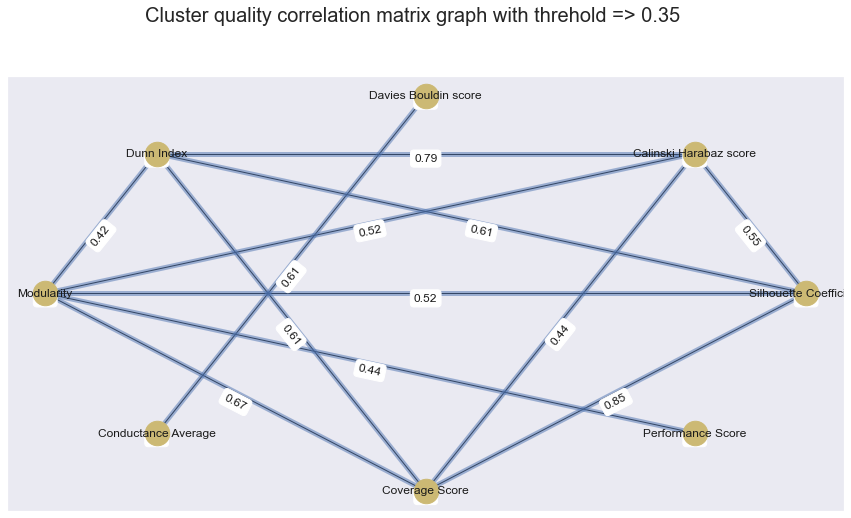

In [80]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

''' set the correlation threshold in the iterval of [-1.0,1.0] it relates to the 
    edge-weights and those edges to remove from the correlation matrix graph '''
_f_corr_thresh = 0.35
''' True: removes all edges => _f_corr_thresh (i.e. to leave edges with correlations < _f_corr_thresh)
    False: removes all edges <= _f_corr_thresh (i.e. to leave edges with correlations < _f_corr_thresh)'''
_remove_gt = False

''' Construct the correlation matrix graph '''
df_corr = _corr_plt_df.corr().round(2)
G = nx.from_pandas_adjacency(df_corr)
edge_weights = nx.get_edge_attributes(G,'weight')
if _remove_gt:
    G.remove_edges_from((e for e, w in edge_weights.items() if w > _f_corr_thresh))
    s_title = "Cluster quality correlation matrix graph with threhold => %0.02f" % _f_corr_thresh
else:
    G.remove_edges_from((e for e, w in edge_weights.items() if w < _f_corr_thresh))
    s_title = "Cluster quality correlation matrix graph with threhold => %0.02f" % _f_corr_thresh
G.name = "Correlation Matrix Graph"

''' Plot the graph with edges representing the correlation '''
plt.figure(figsize=(15,8))
node_pos = pos=nx.circular_layout(G)
#print(node_pos)
nx.draw_networkx(G, node_pos,node_size=600, node_color="y", node_shape='o')
nx.draw_networkx_edges(G, node_pos, width=5.0, alpha=0.5,edge_color="b")
edge_labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, node_pos,
                             edge_labels=edge_labels, label_pos=0.5,
                             font_size=12, font_family="Arial",
                             horizontalalignment='center', verticalalignment='top')
#nx.draw(G)
plt.suptitle(s_title,y=1.0, size=20)
plt.grid(False)
plt.savefig('../images/outputs/cluster_quality_measure_correlation_graph.png', bbox_inches='tight')
plt.show()

### Plot quality measures
___TODO___ Change the color palette using a [different method](https://towardsdatascience.com/how-to-use-your-own-color-palettes-with-seaborn-a45bf5175146)

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



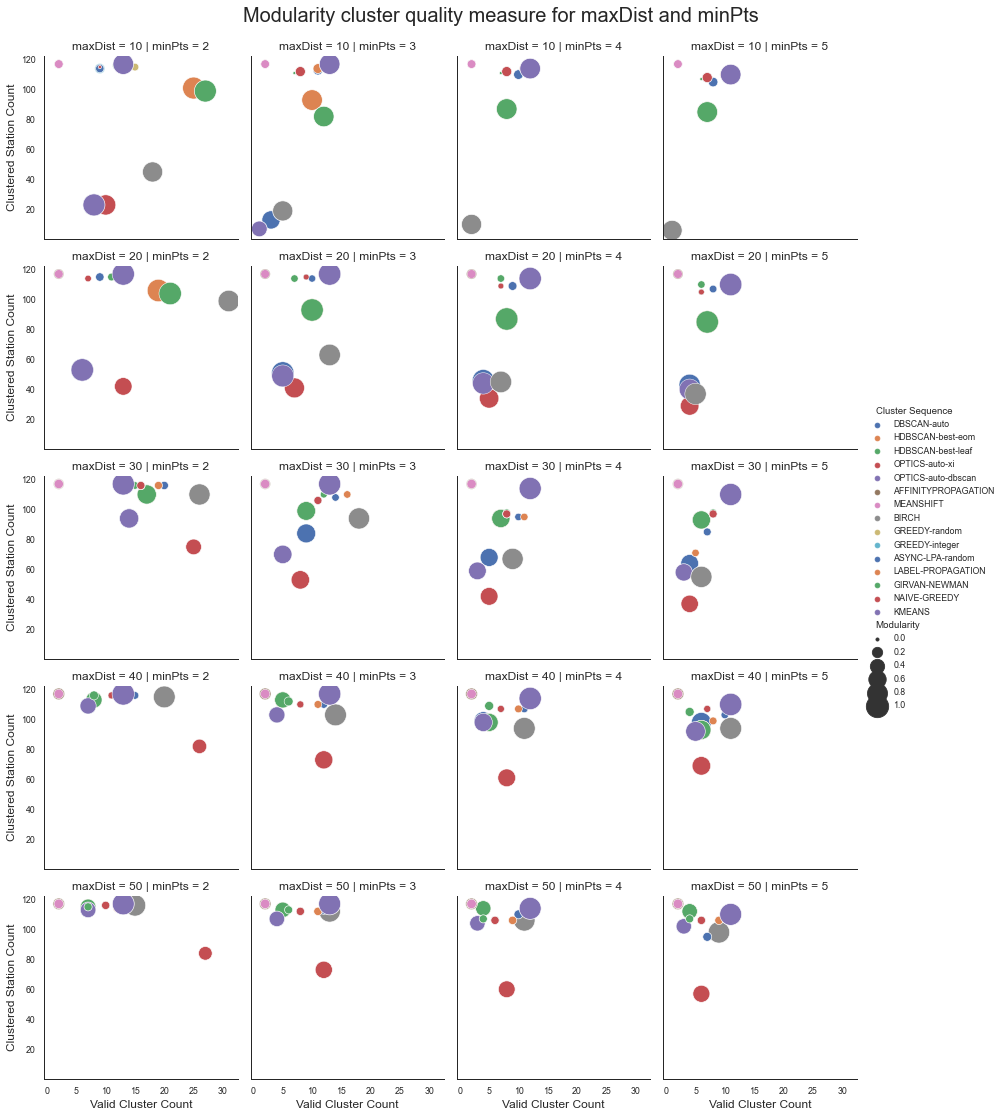

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib
''' @parameter
    use any of the quality measures to view a plot of the cluster sizes and number of stations clustered
    _s_size = {"Silhouette Coefficient","Calinski Harabaz score","Davies Bouldin score","Dunn Index",
            "Modularity","Conductance Average","Coverage Score","Performance Score"])
'''
_s_size = "Modularity"

''' Copy the dataframe of normalized quality measures '''
_plot_df = _norm_df.copy()
''' Plot 1.0 - Davies-Bouldin because small value means good clustering; be easier to visualize '''
_plot_df['Davies Bouldin score'] = 1-_plot_df['Davies Bouldin score']
#_plot_df=_plot_df.rename(columns={"Maximum Distance": "maxDistance", "Minimum Points": "minPts"})
#plot_qlty_msr_df=[cloud_norm_df['Method','Cluster Count','Clustered Station Count',
#                          'Minimum Points','Distance','Davies Bouldin score']]
#plt.figure(figsize=(5,5))
plt.rcParams['figure.figsize']=(10,10)
#fig, g = plt.subplots(2, 2, figsize=(15,2*5), dpi=100, sharex=True, sharey=True)
sns.set_style("white")
sns.set_context("paper", 
                rc={"font.size":12, "axes.labelsize":12}, 
                font_scale=1.0)

_palette = sns.color_palette("deep",
                             len(_plot_df["Cluster Sequence"].unique()))
g=sns.relplot(
    data=_plot_df,
    row='maxDist', col='minPts',
    x="Valid Cluster Count", y="Clustered Station Count",
    hue="Cluster Sequence", size=_s_size,
    palette=_palette, 
    sizes=(10, 500),
    height=3.0
    #facet_kws={'sharey': True, 'sharex': True} --- doesn't work
)

plt.suptitle(_s_size+" cluster quality measure for maxDist and minPts",y=1.02, size=20)
#g.fig.legend(markerscale=1.2)

_s_plot_save_file = str("../images/outputs/relplot "+_s_size+".png").replace(" ","_")
plt.savefig(_s_plot_save_file, bbox_inches='tight')
#plt.ion()
plt.show()

In [270]:
df = _norm_df[_norm_df["Cluster Sequence"]=='BIRCH']
df["Clustered Station Count"].mean()/117

0.63589743589743597

## Pivot-table visualization

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning:


The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning:


The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/pandas/plo

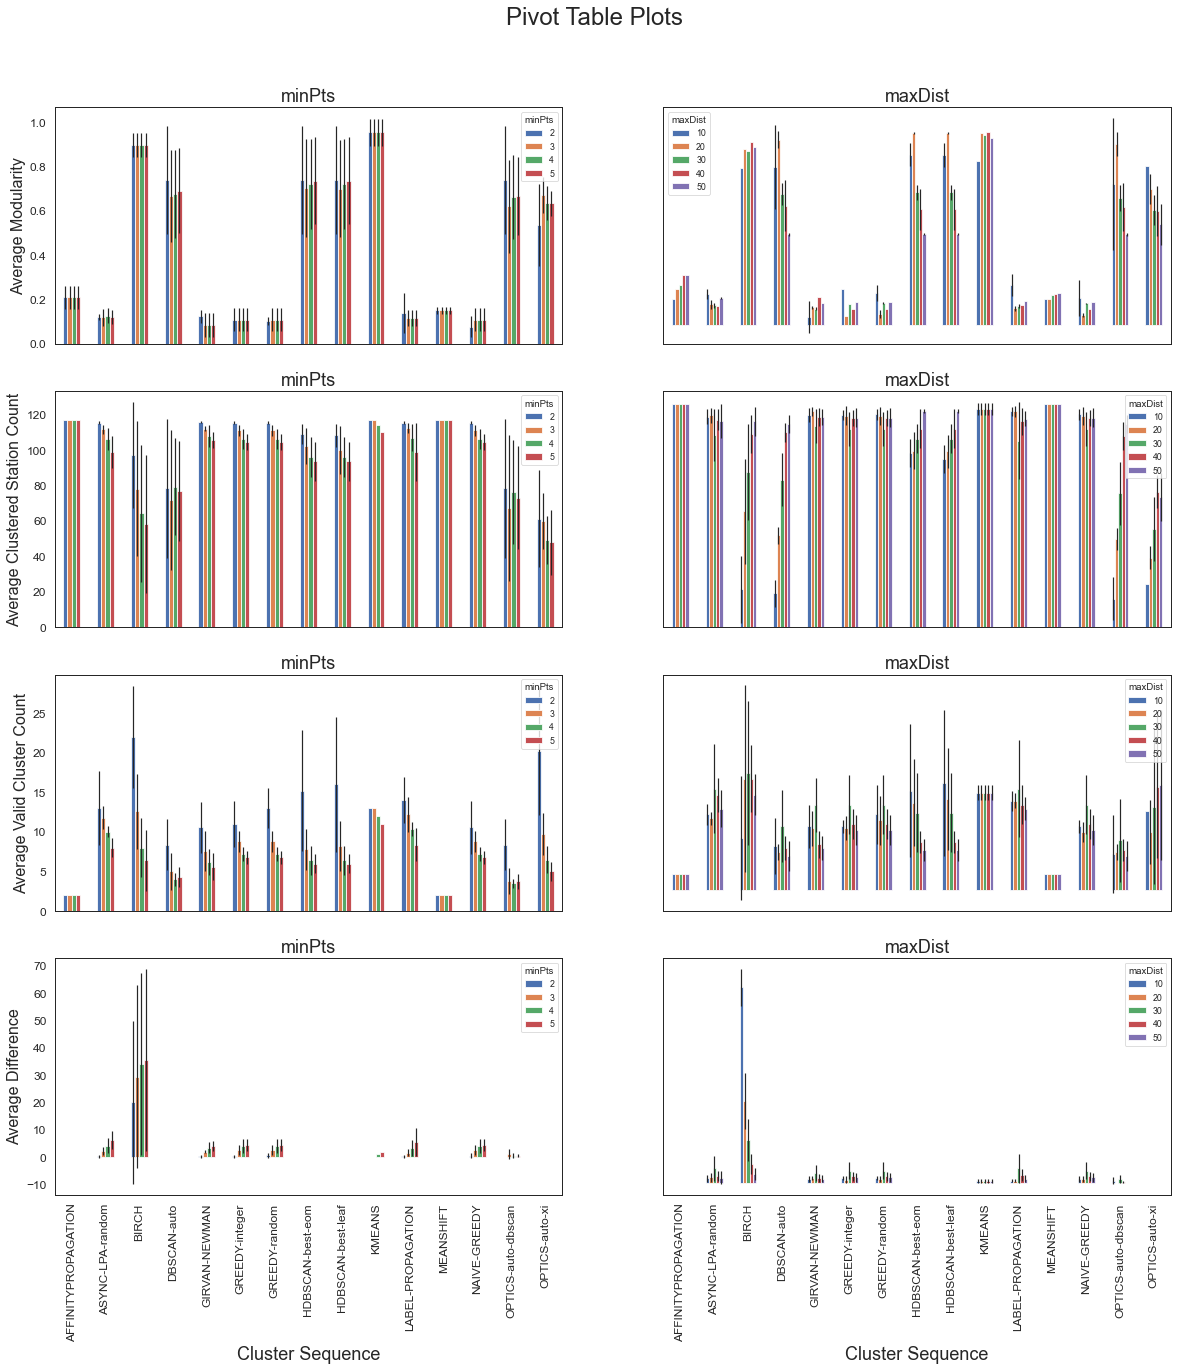

In [274]:
import matplotlib.pyplot as plt
import numpy as np

cols = ["maxDist","minPts","Cluster Sequence", "Modularity",
        "Generated Cluster Count","Valid Cluster Count","Clustered Station Count"]
_pivot_df = _norm_df[cols].copy()
_pivot_df['Difference'] = (_pivot_df['Generated Cluster Count']
                           - _pivot_df['Valid Cluster Count']).astype(float)

#_pivot_df = _pivot_df[_pivot_df['Difference'] > 0]
_pivot_df=_pivot_df.rename(columns={"Maximum Distance": "maxDist", "Minimum Points": "minPts"})
_l_pivtab_cols = ["minPts","maxDist"]
_l_pivtab_vals = ["Modularity","Clustered Station Count","Valid Cluster Count","Difference"]

fig, axes = plt.subplots(nrows=len(_l_pivtab_vals),
                         ncols=len(_l_pivtab_cols),
                         figsize=(20,20),
                         sharex=True,
                         #sharey=False
                        )
#plt.rcParams['figure.figsize']=(15,20)
_l_plots = []
for row_num, row_val in enumerate(_l_pivtab_vals):
    for col_num, col_val in enumerate(_l_pivtab_cols):
        _plot_df = _pivot_df.pivot_table(index=["Cluster Sequence"],
                                               #columns=["minPts","maxDist"],
                                               columns=col_val,
                                               values=row_val,
                                               aggfunc=[np.mean, np.std])
        _l_plots.append(_plot_df)
        
        _plot_df.plot(kind="bar",
                      y="mean",
                      yerr="std",
                      ax=axes[row_num,col_num],
                      #figsize=(10,10),
                      fontsize=12,
                      sharey=True)
        
#        plt.errorbar(x=_plot_df.index, y=_plot_df["mean"], _plot_df["std"], linestyle='None', marker='^')
        axes[row_num,col_num].set_title(col_val,fontdict={'fontsize':18})
        axes[row_num,col_num].set_ylabel("Average "+row_val,fontdict={'fontsize':16})
        axes[row_num,col_num].set_xlabel("Cluster Sequence",fontdict={'fontsize':18})

        plt.suptitle("Pivot Table Plots",y=0.95, size=24)
#g.fig.legend(markerscale=1.2)

_s_plot_save_file = str("../images/outputs/pivot_table_plots.png")
plt.savefig(_s_plot_save_file, bbox_inches='tight')
plt.show()
#_pivot_df
#

In [263]:
print(_l_plots[2],'\n', _l_plots[3])

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



                     mean                           std                      \
minPts                  2      3     4      5         2         3         4   
Cluster Sequence                                                              
AFFINITYPROPAGATION   2.0   2.00   2.0   2.00  0.000000  0.000000  0.000000   
ASYNC-LPA-random     13.0  11.80  10.0   8.00  4.636809  1.483240  0.707107   
BIRCH                22.0  12.60   8.0   6.40  6.442049  4.722288  3.741657   
DBSCAN-auto           8.4   5.00   4.0   4.25  3.209361  2.345208  0.816497   
GIRVAN-NEWMAN        10.6   7.60   6.2   5.60  3.209361  2.509980  1.643168   
GREEDY-integer       11.0   8.80   7.2   6.80  2.915476  1.303840  0.836660   
GREEDY-random        13.0   8.80   7.2   6.80  2.549510  1.303840  0.836660   
HDBSCAN-best-eom     15.2   7.80   6.4   6.00  7.628892  2.588436  1.816590   
HDBSCAN-best-leaf    16.0   8.20   6.4   6.00  8.544004  3.114482  1.816590   
KMEANS               13.0  13.00  12.0  11.00  0.000

### Difference between Generated and Valid clusters

In [88]:
import pandas as pd
import plotly.graph_objects as go
from scipy.stats import ks_2samp
#import seaborn as sns
#import matplotlib.pyplot as plt
#%matplotlib inline

cols = ['maxDist','minPts','Cluster Sequence','Generated Cluster Count','Valid Cluster Count']
_df_clust_diff = _results_df[cols].copy()
_df_clust_diff['Difference'] = (_df_clust_diff['Generated Cluster Count'] 
                                - _df_clust_diff['Valid Cluster Count']).astype(float)
''' consider only records with difference != 0 '''
_diff_df = _df_clust_diff[_df_clust_diff['Difference'] > 0]
''' apply two sample KS-test to all sequences '''
_plot_df=pd.DataFrame([], columns=['Sequence','maxDiff','1-Pvalue'])
for each_seq in _diff_df['Cluster Sequence'].unique():
    _df_temp = _diff_df[_diff_df['Cluster Sequence'] ==each_seq]
    stat, pval = ks_2samp(_df_temp['Generated Cluster Count'],_df_temp['Valid Cluster Count'])
    _plot_df=_plot_df.append({'Sequence':each_seq,'maxDiff':stat, '1-Pvalue':1-pval}, ignore_index=True)

categories = _plot_df['Sequence'].to_list()
fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=_plot_df['1-Pvalue'],
      theta=categories,
      fill='toself',
      name='1-Pvalue'
))
fig.add_trace(go.Scatterpolar(
      r=_plot_df['maxDiff'],
      theta=categories,
      fill='toself',
      name='maxDiff'
))

fig.update_layout(
    polar=dict(radialaxis=dict(visible=True,range=[0, 1])),
    title_font_color="red",
    title={'text': "KS Test of Sequences with Differences between Generated and Valid Clusters",
           'y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'},
    legend=dict(yanchor="top",y=0.99,xanchor="left",x=0.01)
)
''' Need to install kaleido to write image to file'''
#_s_plot_save_file = str("../images/outputs/radar_plot_ks_test.png").replace(" ","_")
#fig.write_image(_s_plot_save_file)
fig.show()

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



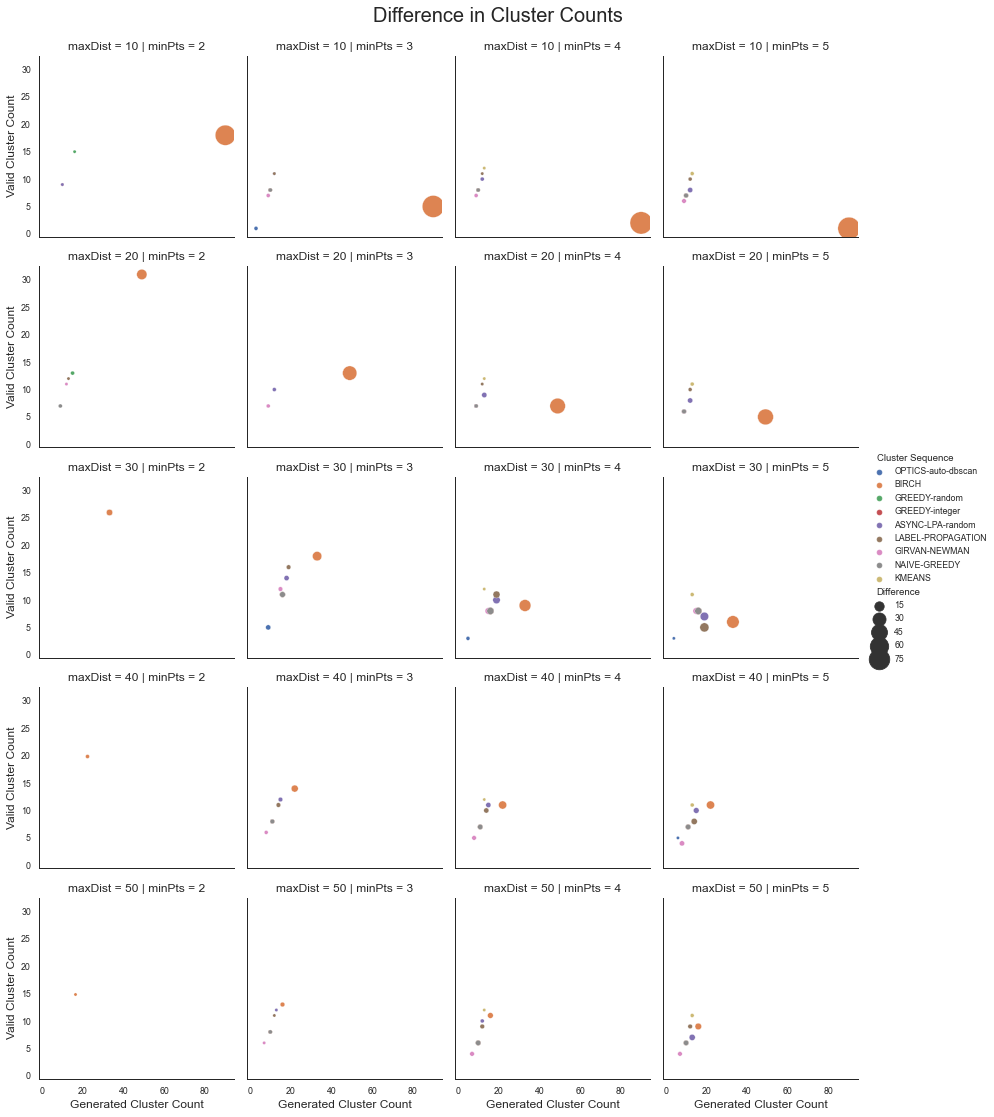

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

cols = ['maxDist','minPts','Cluster Sequence',
        'Generated Cluster Count','Valid Cluster Count']
_df_clust_diff = _results_df[cols].copy()
_df_clust_diff['Difference'] = (_df_clust_diff['Generated Cluster Count'] 
                                - _df_clust_diff['Valid Cluster Count']).astype(float)
_df_clust_diff = _df_clust_diff[_df_clust_diff['Difference'] > 0]
_df_clust_diff=_df_clust_diff.rename(columns={"Maximum Distance": "maxDist", "Minimum Points": "minPts"})
plt.rcParams['figure.figsize']=(10,10)
#fig, g = plt.subplots(2, 2, figsize=(15,2*5), dpi=100, sharex=True, sharey=True)
sns.set_style("white")
sns.set_context("paper", 
                rc={"font.size":12, "axes.labelsize":12}, 
                font_scale=1.0)
#g = sns.FacetGrid(data=_df_clust_diff, col="minPts", row="maxDistance")
#g.map(sns.histplot, x=_df_clust_diff["Difference"])

g=sns.relplot(
    data=_df_clust_diff,
    row='maxDist', col='minPts',
    x="Generated Cluster Count", y="Valid Cluster Count",
    hue="Cluster Sequence", size="Difference",
    palette='deep', sizes=(10, 500),
    height=3.0
    #facet_kws={'sharey': True, 'sharex': True} --- doesn't work
)

#for i,ax in enumerate(g.axes):
#    ax[i,0].axhline(200, ls='--', linewidth=3, color='red')

plt.suptitle("Difference in Cluster Counts",y=1.02, size=20)
#g.fig.legend(markerscale=1.2)

_s_plot_save_file = str("../images/outputs/relplot_cluster_diff.png")
plt.savefig(_s_plot_save_file, bbox_inches='tight')
plt.show()

## Redundant Code

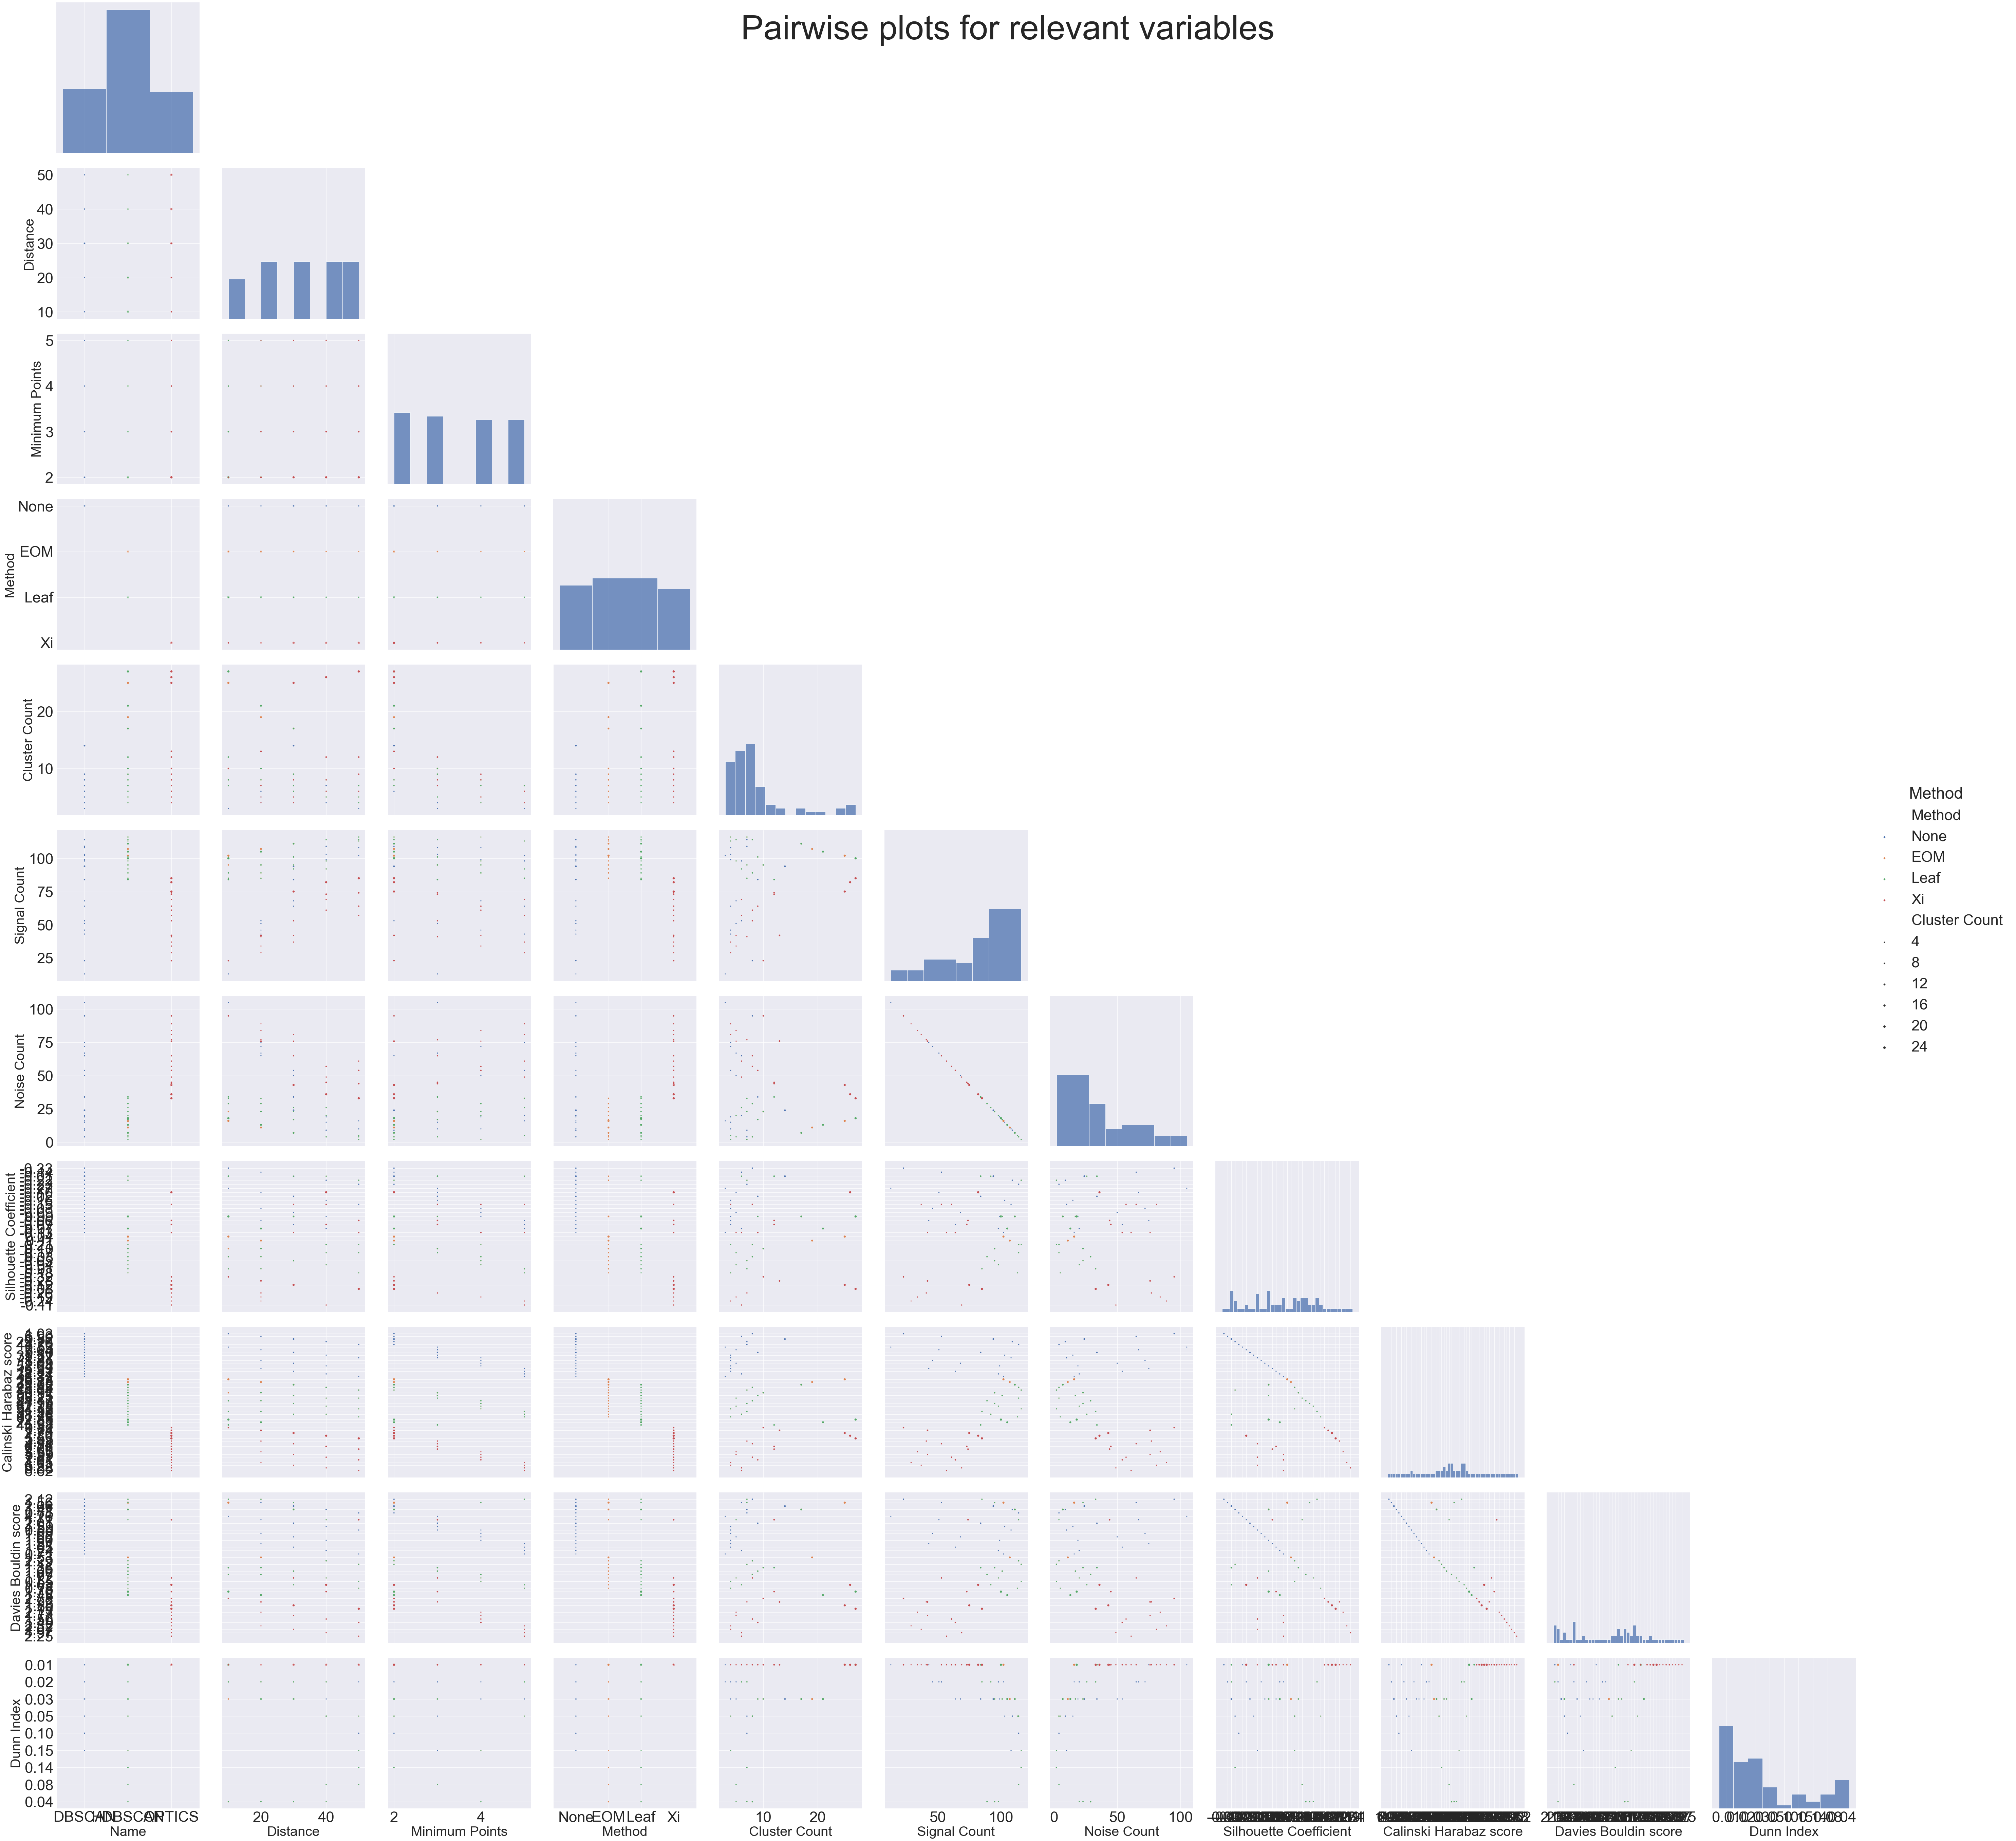

In [174]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pg_plot_df = cloud_clust_df.copy()
lst_vars = list(pg_plot_df.columns)
#lst_vars = list([''])
#x_vars=[cloud_clust_df['Distance'],cloud_clust_df['Minimum Points'],
#        cloud_clust_df['Cluster Count'],cloud_clust_df['Signal Count'],
#        cloud_clust_df['Noise Count']]
#y_vars=[cloud_clust_df['Silhouette Coefficient'],cloud_clust_df['Calinski Harabaz score'],
#        cloud_clust_df['Davies Bouldin score'],cloud_clust_df['Dunn Index']]
sns.color_palette("husl", 4)
sns.set_context("paper", rc={"font.size":8, "axes.labelsize":40}, font_scale=5)
''' kind = hist, scatter, '''
#g = sns.PairGrid(cloud_clust_df, hue='Method_Code', corner=True,hue_order=None,
#                 kind='scatter', diag_kind='hist', height=7,markers='o',
#                 plot_kws={"s": 200}, color=".3")
g = sns.PairGrid(pg_plot_df, hue="Method", vars=lst_vars, corner=True, height=7)
g.map_diag(sns.histplot, hue=None)
#g.map_upper(sns.scatterplot)
#g.map_lower(sns.kdeplot)
g.map_offdiag(sns.scatterplot,s=200, size=pg_plot_df["Cluster Count"])
g.fig.suptitle("Pairwise plots for relevant variables", size=100) # y= some height > 1
g.add_legend()
#g.fig.legend(markerscale=2)
plt.show()

In [64]:
from scipy.stats import normaltest, ansari, chisquare, chi2, chi2_contingency
import numpy as np

_hypo_test_df = _norm_df.copy()

for p_mesr_idx, p_mesr_name in enumerate(lst_norm_cols):
    p_mesr_arr = _hypo_test_df[p_mesr_name].to_numpy()
    s_norm = ""
    s_chisqr = ""
    norm_stat, norm_p = normaltest(p_mesr_arr)
    chisqr_sta, chisqr_p = chisquare(p_mesr_arr)

    if norm_p < 0.05:
        s_norm = '[Normal distribution]'
    if chisqr_p < 0.05:
        s_chisqr = "[Chisquare]"
    print('%s Mean = %0.04f & Variance = %0.04f %s %s' 
          % (p_mesr_name, np.mean(p_mesr_arr), np.var(p_mesr_arr), s_norm, s_chisqr))
    
    for s_mesr_idx, s_mesr_name in enumerate(lst_norm_cols):
        if s_mesr_idx > p_mesr_idx:
            validity_data = np.array([_hypo_test_df[p_mesr_name],_hypo_test_df[s_mesr_name]])
#            chi_stat, chi_p, chi_dof, expected = chi2_contingency(validity_data,correction=False)
#            print(validity_data[0],validity_data[1])
            ans_stat, ans_p = ansari(validity_data[0],validity_data[1])
#            print('H0: %s is different from %s stat: %0.04f p-value: %0.04f dof: %0.04f' 
#                  % (p_mesr_name,s_mesr_name, stat, p, dof))
            if ans_p < 0.05:
                print('Different from %s with p-value: %0.04f' % (s_mesr_name, ans_p))
            else:
                print('Same as %s with p-value: %0.04f' % (s_mesr_name, ans_p))
    print()

Silhouette Coefficient Mean = 0.4392 & Variance = 0.0897 [Normal distribution] 
Same as Calinski Harabaz score with p-value: 0.1767
Same as Davies Bouldin score with p-value: 0.9118
Different from Dunn Index with p-value: 0.0000
Different from Modularity with p-value: 0.0029
Different from Conductance Average with p-value: 0.0000
Different from Coverage Score with p-value: 0.0000
Same as Performance Score with p-value: 0.3881

Calinski Harabaz score Mean = 0.0751 & Variance = 0.0242 [Normal distribution] 
Different from Davies Bouldin score with p-value: 0.0000
Different from Dunn Index with p-value: 0.0000
Different from Modularity with p-value: 0.0143
Different from Conductance Average with p-value: 0.0000
Same as Coverage Score with p-value: 0.3460
Same as Performance Score with p-value: 0.4069

Davies Bouldin score Mean = 0.1005 & Variance = 0.0197 [Normal distribution] 
Different from Dunn Index with p-value: 0.0000
Different from Modularity with p-value: 0.0026
Different from Con